In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re

import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

from collections import Counter

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DixitShi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DixitShi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DixitShi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
%config Completer.use_jedi = False

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

### EDA

In [4]:
print("Train data size : ", df_train.shape)
print("Test data size : ", df_test.shape)

Train data size :  (7613, 5)
Test data size :  (3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
# Few "keyword" and more than 30% "location" data is missing as seen by above 2 commands

pd.options.display.max_rows = 500
pd.options.display.max_colwidth = None
# pd.reset_option('all')

In [9]:
df_train.groupby("keyword")["id"].count()

keyword
ablaze                   36
accident                 35
aftershock               34
airplane%20accident      35
ambulance                38
annihilated              34
annihilation             29
apocalypse               32
armageddon               42
army                     34
arson                    32
arsonist                 34
attack                   36
attacked                 35
avalanche                30
battle                   26
bioterror                37
bioterrorism             30
blaze                    38
blazing                  34
bleeding                 35
blew%20up                33
blight                   32
blizzard                 37
blood                    35
bloody                   35
blown%20up               33
body%20bag               33
body%20bagging           33
body%20bags              41
bomb                     34
bombed                   38
bombing                  29
bridge%20collapse        35
buildings%20burning      35
buildings%20

In [10]:
df_train.groupby("location")["id"].count()

location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Name: id, Length: 3341, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

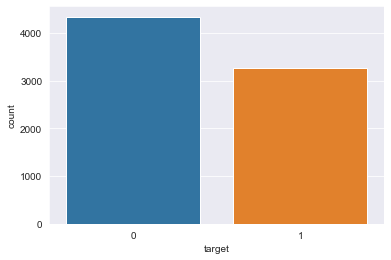

In [11]:
# Tweet Distribution
sns.set_style("darkgrid")
sns.countplot(x="target", data=df_train)

### Checking if there is any difference in the length of Normal vs Disaster tweets

C:\Users\DixitShi\Anaconda3\envs\Env1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\DixitShi\Anaconda3\envs\Env1\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='text'>

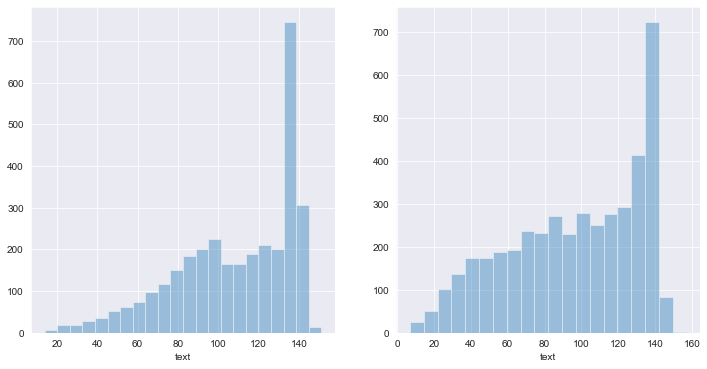

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

char_len = df_train[df_train["target"]==1]["text"].str.len()
sns.distplot(char_len, ax=axes[0], kde=False)

char_len = df_train[df_train["target"]==0]["text"].str.len()
sns.distplot(char_len, ax=axes[1], kde=False)

### Top 10 keywords in Normal vs Disaster tweets

C:\Users\DixitShi\Anaconda3\envs\Env1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DixitShi\Anaconda3\envs\Env1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Disaster Tweets')

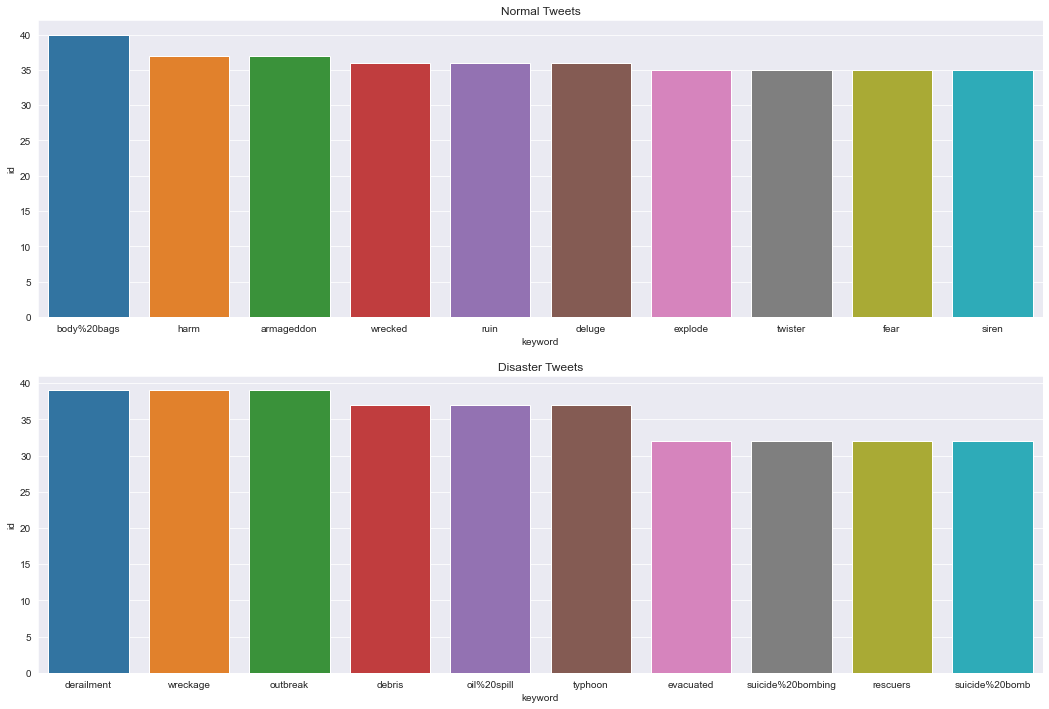

In [13]:
fig, axes = plt.subplots(2,1, figsize=(18,12))

temp = pd.DataFrame(df_train[df_train["target"]==0].groupby("keyword")["id"].count())
temp.sort_values("id", ascending=False, inplace=True)
sns.barplot(temp.index[:10], temp["id"][:10], ax=axes[0]).set_title("Normal Tweets")

temp = pd.DataFrame(df_train[df_train["target"]==1].groupby("keyword")["id"].count())
temp.sort_values("id", ascending=False, inplace=True)
sns.barplot(temp.index[:10], temp["id"][:10], ax=axes[1]).set_title("Disaster Tweets")

### Hashtags

In [14]:
def extract_hashtags(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        if ht:
            hashtags.extend(ht)
    
    return hashtags

ht_normal = extract_hashtags(df_train[df_train["target"] == 0]["text"])
ht_disaster = extract_hashtags(df_train[df_train["target"] == 1]["text"])


Text(0.5, 1.0, 'Disaster Tweets')

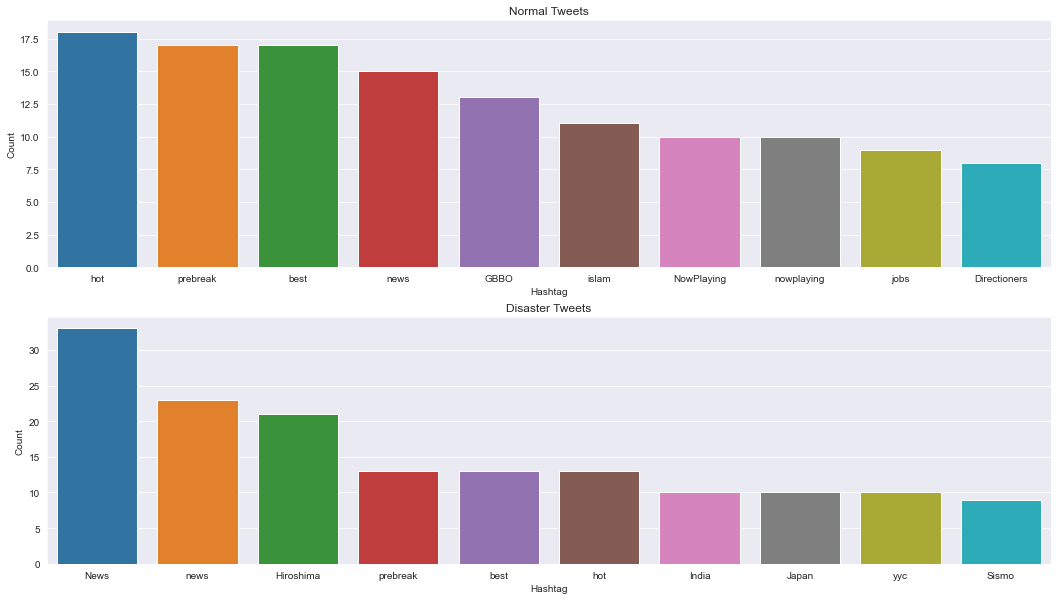

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

ht_freq = nltk.FreqDist(ht_normal)
df_freq = pd.DataFrame({"Hashtag": list(ht_freq.keys()),
                       "Count": list(ht_freq.values())})
df_freq.sort_values(by="Count", ascending=False, inplace=True)
sns.barplot(data=df_freq.head(10), x="Hashtag", y="Count", ax=axes[0]).set_title("Normal Tweets")

ht_freq = nltk.FreqDist(ht_disaster)
df_freq = pd.DataFrame({"Hashtag": list(ht_freq.keys()),
                       "Count": list(ht_freq.values())})
df_freq.sort_values(by="Count", ascending=False, inplace=True)
sns.barplot(data=df_freq.head(10), x="Hashtag", y="Count", ax=axes[1]).set_title("Disaster Tweets")

### Data cleaning and pre-processing

In [16]:
df_merged = df_train.append(df_test, ignore_index=True)
df_merged.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


In [17]:
def remove_re(text, pattern):
    re_obj = re.compile(pattern)
    text = re_obj.sub(r"", text)
    return text

In [18]:
# Remove twitter handles

df_merged["text"] = df_merged["text"].apply(lambda x : remove_re(x, "@[\w]*"))
df_merged[df_merged["text"].str.contains("@")]

,id,keyword,location,text,target


In [19]:
# Remove URLs and HTML tags

df_merged["text"] = df_merged["text"].apply(lambda x : remove_re(x, "https?://\S+|www\.\S+"))
df_merged["text"] = df_merged["text"].apply(lambda x : remove_re(x, "<.*>"))

In [20]:
# Remove punctuations, special characters, numbers

df_merged["text"] = df_merged["text"].apply(lambda x : remove_re(x, "[^a-zA-Z# ]"))
df_merged.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1.0
3,6,NaN,NaN,people receive #wildfires evacuation orders in California,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


In [21]:
# Remove stop words and transform into lower case

stop = list(stop)
stop.append("amp")
stop = set(stop)

def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w.lower() for w in word_tokens if not w in stop]
    filtered_tweet = " ".join(filtered_sentence)
    return filtered_tweet

df_merged["text"] = df_merged["text"].apply(lambda x : remove_stop_words(x))
df_merged.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds reason # earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,all residents asked shelter place notified officers no evacuation shelter place orders expected,1.0
3,6,NaN,NaN,people receive # wildfires evacuation orders california,1.0
4,7,NaN,NaN,just got sent photo ruby # alaska smoke # wildfires pours school,1.0


In [22]:
# Lemmatization

lemmatizer = WordNetLemmatizer()

def get_pos(word):
    
    w_synsets = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len(  [item for item in w_synsets if item.pos()=="n"]  )#Noun
    pos_counts["v"] = len(  [item for item in w_synsets if item.pos()=="v"]  )#Verb
    pos_counts["a"] = len(  [item for item in w_synsets if item.pos()=="a"]  )#Adjective
    pos_counts["r"] = len(  [item for item in w_synsets if item.pos()=="r"]  )#Adverb
    most_common_pos_list = pos_counts.most_common(3)
    
    return most_common_pos_list[0][0]

def to_lemma(text):
    
    tokens = word_tokenize(text)
    lemmas = []
    
    for i in tokens:
        lemma = lemmatizer.lemmatize(i, get_pos(i))
        lemmas.append(lemma)
        
    final_tweet = " ".join(lemmas)
    
    return final_tweet


In [23]:
df_merged["text"] = df_merged["text"].apply(lambda x : to_lemma(x))
df_merged.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deed reason # earthquake may allah forgive u,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,all resident ask shelter place notify officer no evacuation shelter place order expect,1.0
3,6,NaN,NaN,people receive # wildfire evacuation order california,1.0
4,7,NaN,NaN,just get send photo ruby # alaska smoke # wildfire pour school,1.0


### Word Cloud

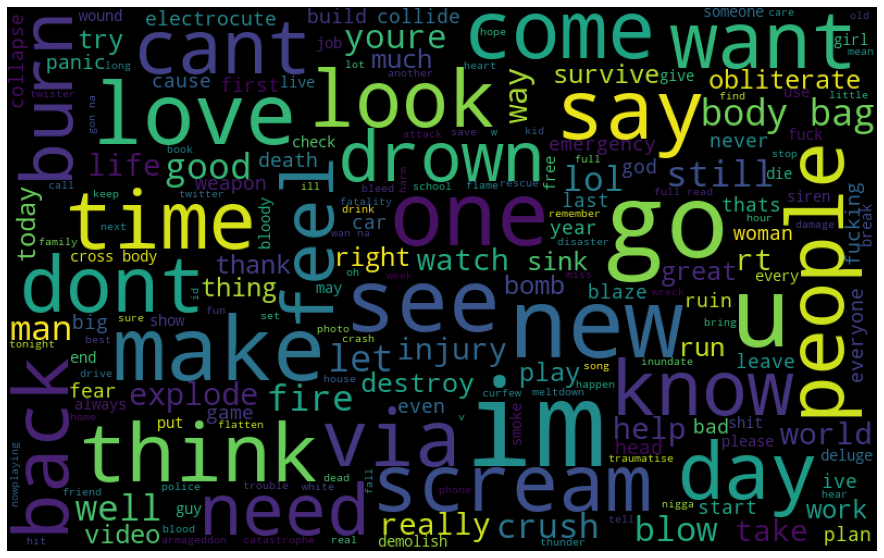

In [24]:
# Word CLoud for Normal Tweets

wCLoud = WordCloud(width=800, height=500, random_state=10, max_font_size=110
                  ).generate(" ".join([text for text in df_merged[df_merged["target"] == 0]["text"]]))

plt.figure(figsize=(16, 10))
plt.imshow(wCLoud)
plt.axis("off")
plt.show()

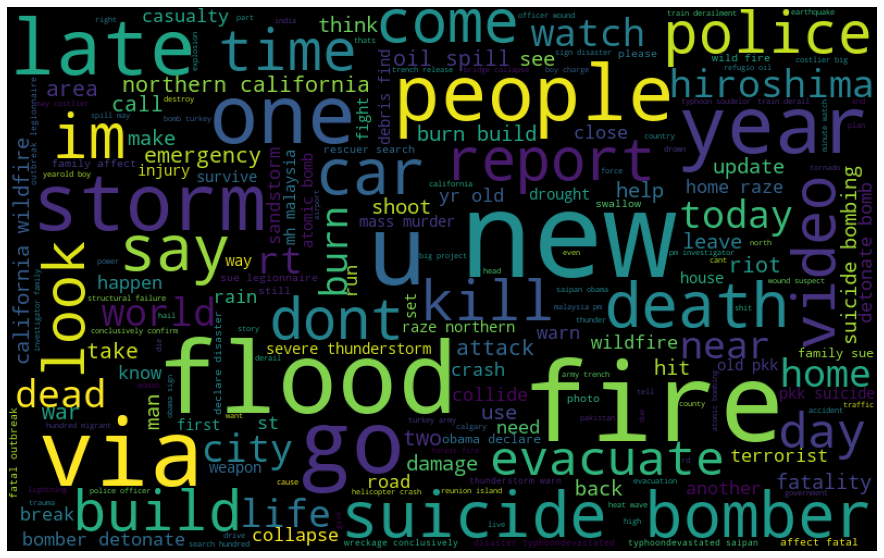

In [25]:
# Word CLoud for Disaster Tweets

wCLoud = WordCloud(width=800, height=500, random_state=10, max_font_size=110
                  ).generate(" ".join([text for text in df_merged[df_merged["target"] == 1]["text"]]))

plt.figure(figsize=(16, 10))
plt.imshow(wCLoud)
plt.axis("off")
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

final_train = df_merged[:7613]
final_test = df_merged[7613:]

x_train, x_test, y_train, y_test = train_test_split(final_train["text"], final_train["target"],
                                                    stratify=final_train["target"], test_size=0.2, random_state=42, )

x_for_pred = final_test["text"]

### Feature Engineering and Modelin

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score

kFold = StratifiedKFold(n_splits=10)

pipeline1 = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", MultinomialNB())
    ])

pipeline1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'classifier', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'classifier__alpha', 'classifier__class_prior', 'classifier__fit_prior'])

In [28]:
grid_parameters = {
    "tfidf__max_df":(0.80, 0.85, 0.90), # max_df = 0.50 means "ignore terms that appear in more than 50% of the documents"
    "tfidf__min_df":(0.01, 0.02), # min_df = 0.01 means "ignore terms that appear in less than 1% of the documents"
    "tfidf__ngram_range":[(1,1), (1,2)],
    "tfidf__stop_words":[None, stop],
    "classifier__alpha":[1, 0.5, 0.1, 0.01] # Learning Rate
}

### Searching for best hyper parameters

In [29]:
# searching for best hyper parameters

best_model = GridSearchCV(estimator=pipeline1, param_grid=grid_parameters, scoring="accuracy", cv=StratifiedKFold(n_splits=10))

# best_model = RandomizedSearchCV(estimator=pipeline1, param_distributions=grid_parameters, scoring="accuracy",
#                                 cv=StratifiedKFold(n_splits=10), n_iter=50, random_state=31, n_jobs=2)
best_model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [1, 0.5, 0.1, 0.01],
                         'tfidf__max_df': (0.8, 0.85, 0.9),
                         'tfidf__min_df': (0.01, 0.02),
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None,
                                               {'a', 'about', 'above', 'after',
                                                'again', 'against', 'ain',
                                                'all', 'am', 'amp', 'an', 'and',
                                                'any', 'are', 'aren', "aren't",
                                                'as', 'at', 'be', 'because',
                                                'been', 'before', 'being',
        

In [30]:
best_model.best_params_

{'classifier__alpha': 0.5,
 'tfidf__max_df': 0.8,
 'tfidf__min_df': 0.01,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': None}

### Cross-Validation of best found hyper parameters

In [31]:
# cross-validation of best found hyper parameters

pipeline2 = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(max_df=0.8, min_df=0.01, ngram_range=(1,1), stop_words=None)),
        ("classifier", MultinomialNB(alpha=0.5))
    ])

cross_val_score(estimator=pipeline2, X=x_train, y=y_train, scoring="accuracy", cv=StratifiedKFold(n_splits=10), n_jobs=2).mean()

# cross_val_score(estimator=best_model, X=x_train, y=y_train, scoring="accuracy", cv=StratifiedKFold(n_splits=10),
#                 n_jobs=2).mean()

0.7133004926108375

In [32]:
# model training using best hyper parameters

pipeline2.fit(x_train, y_train)
y_pred = pipeline2.predict(x_test)

### Model performance on the chosen hyper parameters

In [33]:
# Model performance on the chosen hyper parameters

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

print("Accuracy on test set : ", accuracy_score(y_test, y_pred))
print("Confustion Matrix on test set : \n", confusion_matrix(y_test, y_pred))
print("Classification Report on test set : \n", classification_report(y_test, y_pred))

Accuracy on test set :  0.7091267235718975
Confustion Matrix on test set : 
 [[736 133]
 [310 344]]
Classification Report on test set : 
               precision    recall  f1-score   support

         0.0       0.70      0.85      0.77       869
         1.0       0.72      0.53      0.61       654

    accuracy                           0.71      1523
   macro avg       0.71      0.69      0.69      1523
weighted avg       0.71      0.71      0.70      1523



In [34]:
# AUC ROC Score

print("ROC AUC : ", roc_auc_score(y_test, pipeline2.predict_proba(x_test)[:, 1]))

ROC AUC :  0.759296600894557


### Choosing new threshold based on ROC curve

In [35]:
# Choosing new threshold based on ROC curve

fpr, tpr, roc_thresholds = roc_curve(y_test, pipeline2.predict_proba(x_test)[:, 1])

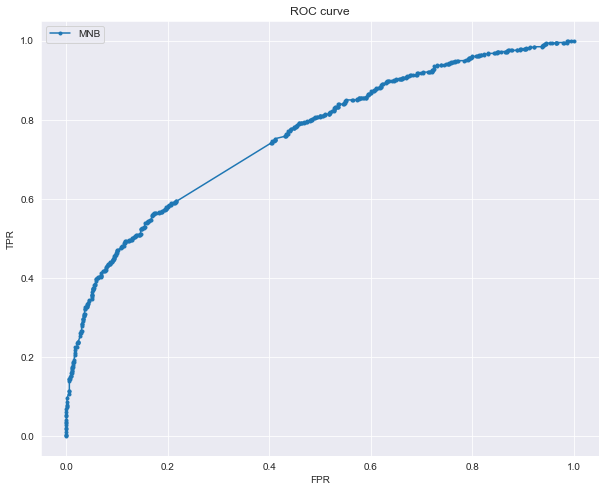

In [36]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, marker=".", label="MNB")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
# plt.show()

In [37]:
import numpy as np

y_prob = pipeline2.predict_proba(x_test)
y_pred_new = [1 if prob>=0.40 else 0 for prob in y_prob[:,1]]

In [38]:
# 0.40 seems to be the best threshold for predicting the disaster tweets(positive class)

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

         0.0       0.77      0.55      0.64       869
         1.0       0.57      0.79      0.66       654

    accuracy                           0.65      1523
   macro avg       0.67      0.67      0.65      1523
weighted avg       0.68      0.65      0.65      1523



### Choosing new threshold based on Precision Recall curve

In [39]:
# Choosing new threshold based on Precision Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob[:,1])

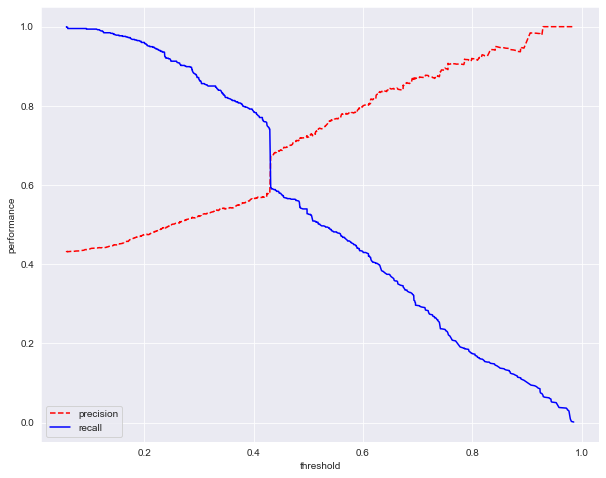

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(pr_thresholds, precision[:-1], "r--", label="precision")
plt.plot(pr_thresholds, recall[:-1], "b-", label="recall")
plt.xlabel("threshold")
plt.ylabel("performance")
plt.legend(loc="best")
plt.show()

#### Best threshold so far still looks around 0.40

## Prediction on final data for submission

In [41]:
final_test.head()

,id,keyword,location,text,target
7613,0,NaN,NaN,just happen terrible car crash,NaN
7614,2,NaN,NaN,hear # earthquake different city stay safe everyone,NaN
7615,3,NaN,NaN,forest fire spot pond goose flee across street i save,NaN
7616,9,NaN,NaN,apocalypse light # spokane # wildfire,NaN
7617,11,NaN,NaN,typhoon soudelor kill china taiwan,NaN


In [42]:
y_prob_final = pipeline2.predict_proba(final_test["text"])
y_pred_final = [1 if prob>=0.40 else 0 for prob in y_prob_final[:,1]]

In [43]:
final_pred_df = pd.DataFrame()
final_pred_df["id"] = final_test["id"]
final_pred_df["target"] = y_pred_final
final_pred_df.head()

,id,target
7613,0,1
7614,2,1
7615,3,1
7616,9,1
7617,11,1


In [44]:
final_pred_df.to_csv('submission.csv',index=False)

PermissionError: [Errno 13] Permission denied: 'submission.csv'